In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['fast_bowl', 'spin_bowl']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)

Total training images: 1710
Total validation images: 432
Total test images: 549
Total images in dataset: 2691


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))

Training images (excluding 'random_occlusion'): 1520
Validation images (excluding 'random_occlusion'): 384
Test images (excluding 'random_occlusion'): 488
Total images (excluding 'random_occlusion'): 2392


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'chromatic_aberration', 'random_occlusion', 'blur', 'gaussian_noise', 'motion_blur', 'low_resolution', 'lens_flare', 'dirty_lens', 'original'}
Validation folders considered: {'chromatic_aberration', 'random_occlusion', 'blur', 'gaussian_noise', 'motion_blur', 'low_resolution', 'lens_flare', 'dirty_lens', 'original'}
Test folders considered: {'chromatic_aberration', 'random_occlusion', 'blur', 'gaussian_noise', 'motion_blur', 'low_resolution', 'lens_flare', 'dirty_lens', 'original'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))

Classes: ['fast_bowl', 'spin_bowl']
Final Training images: 1520
Final Validation images: 384
Final Test images: 488
Total images after filtering: 2392


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'chromatic_aberration', 'blur', 'gaussian_noise', 'motion_blur', 'low_resolution', 'lens_flare', 'dirty_lens', 'original'}
Validation folders considered: {'chromatic_aberration', 'blur', 'gaussian_noise', 'motion_blur', 'low_resolution', 'lens_flare', 'dirty_lens', 'original'}
Test folders considered: {'chromatic_aberration', 'blur', 'gaussian_noise', 'motion_blur', 'low_resolution', 'lens_flare', 'dirty_lens', 'original'}


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import os
import tempfile

# -----------------------------
# 1. Data Preprocessing with Filtering (Swin Transformer - 224x224)
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

# Swin Transformer uses 224x224 input size
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Swin Transformer input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    """Filter out samples containing the ignore_folder in their path"""
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]
    return dataset

# Create and filter datasets
print("üîÑ Loading and filtering datasets for Swin Transformer...")
train_ds = datasets.ImageFolder(f"{data_dir}/train/Bowling", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Bowling", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Bowling", transform=transform)

# Apply filtering
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Display information
classes = train_ds.classes
print(f"‚úÖ Classes: {classes}")
print(f"üìä Dataset Statistics:")
print(f"‚îÇ Training images: {len(train_ds)}")
print(f"‚îÇ Validation images: {len(val_ds)}")
print(f"‚îÇ Test images: {len(test_ds)}")
print(f"‚îÇ Total images (after filtering): {len(train_ds) + len(val_ds) + len(test_ds)}")
print(f"‚îÇ Excluded folder: '{ignore_folder}'")
print(f"‚îÇ Number of classes: {len(classes)}")

# -----------------------------
# 2. Pretrained Swin Transformer Model
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pretrained Swin Transformer (Swin-T)
print("üîÑ Loading pretrained Swin Transformer (Swin-T) from ImageNet...")
model = models.swin_t(pretrained=True)

# Replace final classification layer
# Swin Transformer uses model.head (similar to ViT)
num_features = model.head.in_features  # Get input features (768 for Swin-T)
model.head = nn.Linear(num_features, len(classes))  # Replace final layer
model = model.to(device)

print(f"‚úÖ Model loaded with {len(classes)} output classes")

# Calculate model parameters and size
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Calculate model file size
with tempfile.NamedTemporaryFile(delete=False, suffix='.pth') as tmp_file:
    torch.save(model.state_dict(), tmp_file.name)
    model_size_mb = os.path.getsize(tmp_file.name) / (1024 * 1024)
    os.unlink(tmp_file.name)

print(f"üìä Total parameters: {total_params:,}")
print(f"üìä Trainable parameters: {trainable_params:,}")
print(f"üìä Model file size: {model_size_mb:.2f} MB")
print(f"üìã Model Architecture:")
print(f"‚îÇ Input size: (3, 224, 224)")
print(f"‚îÇ Swin-T features: 768")
print(f"‚îÇ Output classes: {len(classes)}")
print(f"‚îÇ Patch size: 4x4")
print(f"‚îÇ Window size: 7x7")
print(f"‚îÇ Layers: [2, 2, 6, 2] per stage")
print(f"‚îÇ Hierarchical: Multi-scale feature maps")


üîÑ Loading and filtering datasets for Swin Transformer...
‚úÖ Classes: ['fast_bowl', 'spin_bowl']
üìä Dataset Statistics:
‚îÇ Training images: 1520
‚îÇ Validation images: 384
‚îÇ Test images: 488
‚îÇ Total images (after filtering): 2392
‚îÇ Excluded folder: 'random_occlusion'
‚îÇ Number of classes: 2
Using device: cuda
üîÑ Loading pretrained Swin Transformer (Swin-T) from ImageNet...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_T_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_T_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 108M/108M [00:00<00:00, 176MB/s]


‚úÖ Model loaded with 2 output classes
üìä Total parameters: 27,520,892
üìä Trainable parameters: 27,520,892
üìä Model file size: 105.27 MB
üìã Model Architecture:
‚îÇ Input size: (3, 224, 224)
‚îÇ Swin-T features: 768
‚îÇ Output classes: 2
‚îÇ Patch size: 4x4
‚îÇ Window size: 7x7
‚îÇ Layers: [2, 2, 6, 2] per stage
‚îÇ Hierarchical: Multi-scale feature maps



üìã Training Configuration:
‚îÇ Model: Swin Transformer Tiny (pretrained)
‚îÇ Optimizer: Adam (lr=0.0001)
‚îÇ Loss Function: CrossEntropyLoss
‚îÇ Batch Size: 32
‚îÇ Device: cuda
‚îÇ Data: Filtered (excluding 'random_occlusion')

üöÄ Starting Swin Transformer Fine-tuning for 50 epochs...

üìà Epoch 1/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:42<00:00,  1.13it/s, Loss=0.5271, Acc=0.7211]


‚úÖ Training completed in 42.53s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:06<00:00,  1.98it/s, Loss=0.5612, Acc=0.7188]


‚úÖ Validation completed in 6.05s
üåü New best model found! Validation Loss: 0.5612

üìä Epoch 1 Summary:
‚îÇ Train Loss: 0.5271 | Train Acc: 0.7211
‚îÇ Val Loss:   0.5612 | Val Acc:   0.7188
‚îÇ Train Time: 42.53s | Val Time: 6.05s
‚îÇ Total Epoch Time: 48.59s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 2/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:30<00:00,  1.59it/s, Loss=0.1252, Acc=0.9546]


‚úÖ Training completed in 30.24s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.19it/s, Loss=1.1035, Acc=0.6354]


‚úÖ Validation completed in 3.76s

üìä Epoch 2 Summary:
‚îÇ Train Loss: 0.1252 | Train Acc: 0.9546
‚îÇ Val Loss:   1.1035 | Val Acc:   0.6354
‚îÇ Train Time: 30.24s | Val Time: 3.76s
‚îÇ Total Epoch Time: 34.01s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 3/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:30<00:00,  1.55it/s, Loss=0.0397, Acc=0.9868]


‚úÖ Training completed in 30.94s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.15it/s, Loss=1.3532, Acc=0.7344]


‚úÖ Validation completed in 3.81s

üìä Epoch 3 Summary:
‚îÇ Train Loss: 0.0397 | Train Acc: 0.9868
‚îÇ Val Loss:   1.3532 | Val Acc:   0.7344
‚îÇ Train Time: 30.94s | Val Time: 3.81s
‚îÇ Total Epoch Time: 34.76s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 4/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0199, Acc=0.9954]


‚úÖ Training completed in 32.85s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.05it/s, Loss=1.3220, Acc=0.7240]


‚úÖ Validation completed in 3.93s

üìä Epoch 4 Summary:
‚îÇ Train Loss: 0.0199 | Train Acc: 0.9954
‚îÇ Val Loss:   1.3220 | Val Acc:   0.7240
‚îÇ Train Time: 32.85s | Val Time: 3.93s
‚îÇ Total Epoch Time: 36.78s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 5/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:33<00:00,  1.45it/s, Loss=0.0362, Acc=0.9882]


‚úÖ Training completed in 33.14s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.14it/s, Loss=1.9467, Acc=0.6875]


‚úÖ Validation completed in 3.82s

üìä Epoch 5 Summary:
‚îÇ Train Loss: 0.0362 | Train Acc: 0.9882
‚îÇ Val Loss:   1.9467 | Val Acc:   0.6875
‚îÇ Train Time: 33.14s | Val Time: 3.82s
‚îÇ Total Epoch Time: 36.96s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 6/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.47it/s, Loss=0.0351, Acc=0.9875]


‚úÖ Training completed in 32.63s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.15it/s, Loss=1.6581, Acc=0.6953]


‚úÖ Validation completed in 3.82s

üìä Epoch 6 Summary:
‚îÇ Train Loss: 0.0351 | Train Acc: 0.9875
‚îÇ Val Loss:   1.6581 | Val Acc:   0.6953
‚îÇ Train Time: 32.63s | Val Time: 3.82s
‚îÇ Total Epoch Time: 36.45s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 7/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0092, Acc=0.9967]


‚úÖ Training completed in 32.88s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.06it/s, Loss=1.5724, Acc=0.7161]


‚úÖ Validation completed in 3.93s

üìä Epoch 7 Summary:
‚îÇ Train Loss: 0.0092 | Train Acc: 0.9967
‚îÇ Val Loss:   1.5724 | Val Acc:   0.7161
‚îÇ Train Time: 32.88s | Val Time: 3.93s
‚îÇ Total Epoch Time: 36.81s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 8/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.48it/s, Loss=0.0241, Acc=0.9934]


‚úÖ Training completed in 32.53s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.11it/s, Loss=1.6188, Acc=0.6667]


‚úÖ Validation completed in 3.87s

üìä Epoch 8 Summary:
‚îÇ Train Loss: 0.0241 | Train Acc: 0.9934
‚îÇ Val Loss:   1.6188 | Val Acc:   0.6667
‚îÇ Train Time: 32.53s | Val Time: 3.87s
‚îÇ Total Epoch Time: 36.40s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 9/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0071, Acc=0.9987]


‚úÖ Training completed in 32.99s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.14it/s, Loss=1.5897, Acc=0.7031]


‚úÖ Validation completed in 3.83s

üìä Epoch 9 Summary:
‚îÇ Train Loss: 0.0071 | Train Acc: 0.9987
‚îÇ Val Loss:   1.5897 | Val Acc:   0.7031
‚îÇ Train Time: 32.99s | Val Time: 3.83s
‚îÇ Total Epoch Time: 36.82s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 10/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0058, Acc=0.9987]


‚úÖ Training completed in 32.91s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.14it/s, Loss=1.8076, Acc=0.6875]


‚úÖ Validation completed in 3.83s

üìä Epoch 10 Summary:
‚îÇ Train Loss: 0.0058 | Train Acc: 0.9987
‚îÇ Val Loss:   1.8076 | Val Acc:   0.6875
‚îÇ Train Time: 32.91s | Val Time: 3.83s
‚îÇ Total Epoch Time: 36.74s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 11/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.47it/s, Loss=0.0047, Acc=0.9987]


‚úÖ Training completed in 32.67s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.13it/s, Loss=1.8994, Acc=0.6719]


‚úÖ Validation completed in 3.84s

üìä Epoch 11 Summary:
‚îÇ Train Loss: 0.0047 | Train Acc: 0.9987
‚îÇ Val Loss:   1.8994 | Val Acc:   0.6719
‚îÇ Train Time: 32.67s | Val Time: 3.84s
‚îÇ Total Epoch Time: 36.51s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 12/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:33<00:00,  1.45it/s, Loss=0.0019, Acc=1.0000]


‚úÖ Training completed in 33.12s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.15it/s, Loss=2.0973, Acc=0.6771]


‚úÖ Validation completed in 3.81s

üìä Epoch 12 Summary:
‚îÇ Train Loss: 0.0019 | Train Acc: 1.0000
‚îÇ Val Loss:   2.0973 | Val Acc:   0.6771
‚îÇ Train Time: 33.12s | Val Time: 3.81s
‚îÇ Total Epoch Time: 36.94s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 13/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0018, Acc=1.0000]


‚úÖ Training completed in 32.91s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.06it/s, Loss=2.1263, Acc=0.6745]


‚úÖ Validation completed in 3.93s

üìä Epoch 13 Summary:
‚îÇ Train Loss: 0.0018 | Train Acc: 1.0000
‚îÇ Val Loss:   2.1263 | Val Acc:   0.6745
‚îÇ Train Time: 32.91s | Val Time: 3.93s
‚îÇ Total Epoch Time: 36.84s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 14/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0014, Acc=1.0000]


‚úÖ Training completed in 32.85s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.16it/s, Loss=2.0929, Acc=0.6953]


‚úÖ Validation completed in 3.80s

üìä Epoch 14 Summary:
‚îÇ Train Loss: 0.0014 | Train Acc: 1.0000
‚îÇ Val Loss:   2.0929 | Val Acc:   0.6953
‚îÇ Train Time: 32.85s | Val Time: 3.80s
‚îÇ Total Epoch Time: 36.66s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 15/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0171, Acc=0.9947]


‚úÖ Training completed in 32.87s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.12it/s, Loss=1.9146, Acc=0.7109]


‚úÖ Validation completed in 3.84s

üìä Epoch 15 Summary:
‚îÇ Train Loss: 0.0171 | Train Acc: 0.9947
‚îÇ Val Loss:   1.9146 | Val Acc:   0.7109
‚îÇ Train Time: 32.87s | Val Time: 3.84s
‚îÇ Total Epoch Time: 36.72s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 16/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.47it/s, Loss=0.0599, Acc=0.9789]


‚úÖ Training completed in 32.69s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.08it/s, Loss=1.2875, Acc=0.7760]


‚úÖ Validation completed in 3.90s

üìä Epoch 16 Summary:
‚îÇ Train Loss: 0.0599 | Train Acc: 0.9789
‚îÇ Val Loss:   1.2875 | Val Acc:   0.7760
‚îÇ Train Time: 32.69s | Val Time: 3.90s
‚îÇ Total Epoch Time: 36.60s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 17/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.47it/s, Loss=0.0233, Acc=0.9928]


‚úÖ Training completed in 32.65s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.08it/s, Loss=1.1460, Acc=0.7266]


‚úÖ Validation completed in 3.89s

üìä Epoch 17 Summary:
‚îÇ Train Loss: 0.0233 | Train Acc: 0.9928
‚îÇ Val Loss:   1.1460 | Val Acc:   0.7266
‚îÇ Train Time: 32.65s | Val Time: 3.89s
‚îÇ Total Epoch Time: 36.54s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 18/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.47it/s, Loss=0.0120, Acc=0.9967]


‚úÖ Training completed in 32.66s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.02it/s, Loss=1.3545, Acc=0.7552]


‚úÖ Validation completed in 3.97s

üìä Epoch 18 Summary:
‚îÇ Train Loss: 0.0120 | Train Acc: 0.9967
‚îÇ Val Loss:   1.3545 | Val Acc:   0.7552
‚îÇ Train Time: 32.66s | Val Time: 3.97s
‚îÇ Total Epoch Time: 36.64s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 19/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0015, Acc=1.0000]


‚úÖ Training completed in 32.91s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.13it/s, Loss=1.5828, Acc=0.7057]


‚úÖ Validation completed in 3.84s

üìä Epoch 19 Summary:
‚îÇ Train Loss: 0.0015 | Train Acc: 1.0000
‚îÇ Val Loss:   1.5828 | Val Acc:   0.7057
‚îÇ Train Time: 32.91s | Val Time: 3.84s
‚îÇ Total Epoch Time: 36.75s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 20/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0008, Acc=1.0000]


‚úÖ Training completed in 32.77s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.09it/s, Loss=1.6606, Acc=0.7240]


‚úÖ Validation completed in 3.89s

üìä Epoch 20 Summary:
‚îÇ Train Loss: 0.0008 | Train Acc: 1.0000
‚îÇ Val Loss:   1.6606 | Val Acc:   0.7240
‚îÇ Train Time: 32.77s | Val Time: 3.89s
‚îÇ Total Epoch Time: 36.67s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 21/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.47it/s, Loss=0.0022, Acc=0.9993]


‚úÖ Training completed in 32.63s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.14it/s, Loss=1.7013, Acc=0.7161]


‚úÖ Validation completed in 3.83s

üìä Epoch 21 Summary:
‚îÇ Train Loss: 0.0022 | Train Acc: 0.9993
‚îÇ Val Loss:   1.7013 | Val Acc:   0.7161
‚îÇ Train Time: 32.63s | Val Time: 3.83s
‚îÇ Total Epoch Time: 36.46s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 22/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0017, Acc=0.9993]


‚úÖ Training completed in 32.89s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.10it/s, Loss=1.9011, Acc=0.7083]


‚úÖ Validation completed in 3.88s

üìä Epoch 22 Summary:
‚îÇ Train Loss: 0.0017 | Train Acc: 0.9993
‚îÇ Val Loss:   1.9011 | Val Acc:   0.7083
‚îÇ Train Time: 32.89s | Val Time: 3.88s
‚îÇ Total Epoch Time: 36.77s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 23/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0013, Acc=0.9993]


‚úÖ Training completed in 32.97s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.07it/s, Loss=1.8759, Acc=0.7266]


‚úÖ Validation completed in 3.91s

üìä Epoch 23 Summary:
‚îÇ Train Loss: 0.0013 | Train Acc: 0.9993
‚îÇ Val Loss:   1.8759 | Val Acc:   0.7266
‚îÇ Train Time: 32.97s | Val Time: 3.91s
‚îÇ Total Epoch Time: 36.88s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 24/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.47it/s, Loss=0.0113, Acc=0.9987]


‚úÖ Training completed in 32.76s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.08it/s, Loss=2.0909, Acc=0.7344]


‚úÖ Validation completed in 3.89s

üìä Epoch 24 Summary:
‚îÇ Train Loss: 0.0113 | Train Acc: 0.9987
‚îÇ Val Loss:   2.0909 | Val Acc:   0.7344
‚îÇ Train Time: 32.76s | Val Time: 3.89s
‚îÇ Total Epoch Time: 36.65s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 25/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.47it/s, Loss=0.0375, Acc=0.9875]


‚úÖ Training completed in 32.63s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.11it/s, Loss=0.9705, Acc=0.7344]


‚úÖ Validation completed in 3.86s

üìä Epoch 25 Summary:
‚îÇ Train Loss: 0.0375 | Train Acc: 0.9875
‚îÇ Val Loss:   0.9705 | Val Acc:   0.7344
‚îÇ Train Time: 32.63s | Val Time: 3.86s
‚îÇ Total Epoch Time: 36.50s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 26/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0188, Acc=0.9941]


‚úÖ Training completed in 32.83s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.11it/s, Loss=1.5406, Acc=0.7448]


‚úÖ Validation completed in 3.86s

üìä Epoch 26 Summary:
‚îÇ Train Loss: 0.0188 | Train Acc: 0.9941
‚îÇ Val Loss:   1.5406 | Val Acc:   0.7448
‚îÇ Train Time: 32.83s | Val Time: 3.86s
‚îÇ Total Epoch Time: 36.69s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 27/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0144, Acc=0.9928]


‚úÖ Training completed in 32.90s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.09it/s, Loss=1.2564, Acc=0.7344]


‚úÖ Validation completed in 3.89s

üìä Epoch 27 Summary:
‚îÇ Train Loss: 0.0144 | Train Acc: 0.9928
‚îÇ Val Loss:   1.2564 | Val Acc:   0.7344
‚îÇ Train Time: 32.90s | Val Time: 3.89s
‚îÇ Total Epoch Time: 36.79s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 28/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0299, Acc=0.9895]


‚úÖ Training completed in 32.83s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.07it/s, Loss=1.9240, Acc=0.6901]


‚úÖ Validation completed in 3.91s

üìä Epoch 28 Summary:
‚îÇ Train Loss: 0.0299 | Train Acc: 0.9895
‚îÇ Val Loss:   1.9240 | Val Acc:   0.6901
‚îÇ Train Time: 32.83s | Val Time: 3.91s
‚îÇ Total Epoch Time: 36.74s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 29/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.47it/s, Loss=0.0191, Acc=0.9947]


‚úÖ Training completed in 32.74s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.07it/s, Loss=2.4168, Acc=0.6693]


‚úÖ Validation completed in 3.92s

üìä Epoch 29 Summary:
‚îÇ Train Loss: 0.0191 | Train Acc: 0.9947
‚îÇ Val Loss:   2.4168 | Val Acc:   0.6693
‚îÇ Train Time: 32.74s | Val Time: 3.92s
‚îÇ Total Epoch Time: 36.66s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 30/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0092, Acc=0.9993]


‚úÖ Training completed in 32.96s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.18it/s, Loss=1.8173, Acc=0.6667]


‚úÖ Validation completed in 3.78s

üìä Epoch 30 Summary:
‚îÇ Train Loss: 0.0092 | Train Acc: 0.9993
‚îÇ Val Loss:   1.8173 | Val Acc:   0.6667
‚îÇ Train Time: 32.96s | Val Time: 3.78s
‚îÇ Total Epoch Time: 36.74s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 31/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.48it/s, Loss=0.0037, Acc=0.9993]


‚úÖ Training completed in 32.52s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.13it/s, Loss=1.8580, Acc=0.6667]


‚úÖ Validation completed in 3.84s

üìä Epoch 31 Summary:
‚îÇ Train Loss: 0.0037 | Train Acc: 0.9993
‚îÇ Val Loss:   1.8580 | Val Acc:   0.6667
‚îÇ Train Time: 32.52s | Val Time: 3.84s
‚îÇ Total Epoch Time: 36.37s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 32/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0026, Acc=0.9993]


‚úÖ Training completed in 32.95s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.12it/s, Loss=1.5725, Acc=0.7057]


‚úÖ Validation completed in 3.85s

üìä Epoch 32 Summary:
‚îÇ Train Loss: 0.0026 | Train Acc: 0.9993
‚îÇ Val Loss:   1.5725 | Val Acc:   0.7057
‚îÇ Train Time: 32.95s | Val Time: 3.85s
‚îÇ Total Epoch Time: 36.81s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 33/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.47it/s, Loss=0.0027, Acc=0.9987]


‚úÖ Training completed in 32.56s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.10it/s, Loss=2.1008, Acc=0.6562]


‚úÖ Validation completed in 3.88s

üìä Epoch 33 Summary:
‚îÇ Train Loss: 0.0027 | Train Acc: 0.9987
‚îÇ Val Loss:   2.1008 | Val Acc:   0.6562
‚îÇ Train Time: 32.56s | Val Time: 3.88s
‚îÇ Total Epoch Time: 36.44s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 34/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0023, Acc=0.9993]


‚úÖ Training completed in 32.82s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.13it/s, Loss=2.4610, Acc=0.6693]


‚úÖ Validation completed in 3.84s

üìä Epoch 34 Summary:
‚îÇ Train Loss: 0.0023 | Train Acc: 0.9993
‚îÇ Val Loss:   2.4610 | Val Acc:   0.6693
‚îÇ Train Time: 32.82s | Val Time: 3.84s
‚îÇ Total Epoch Time: 36.67s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 35/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0108, Acc=0.9980]


‚úÖ Training completed in 32.80s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.08it/s, Loss=2.0196, Acc=0.7031]


‚úÖ Validation completed in 3.89s

üìä Epoch 35 Summary:
‚îÇ Train Loss: 0.0108 | Train Acc: 0.9980
‚îÇ Val Loss:   2.0196 | Val Acc:   0.7031
‚îÇ Train Time: 32.80s | Val Time: 3.89s
‚îÇ Total Epoch Time: 36.69s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 36/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.47it/s, Loss=0.0137, Acc=0.9967]


‚úÖ Training completed in 32.72s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.12it/s, Loss=2.1528, Acc=0.6589]


‚úÖ Validation completed in 3.85s

üìä Epoch 36 Summary:
‚îÇ Train Loss: 0.0137 | Train Acc: 0.9967
‚îÇ Val Loss:   2.1528 | Val Acc:   0.6589
‚îÇ Train Time: 32.72s | Val Time: 3.85s
‚îÇ Total Epoch Time: 36.58s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 37/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.47it/s, Loss=0.0033, Acc=0.9987]


‚úÖ Training completed in 32.70s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.13it/s, Loss=2.0761, Acc=0.6953]


‚úÖ Validation completed in 3.83s

üìä Epoch 37 Summary:
‚îÇ Train Loss: 0.0033 | Train Acc: 0.9987
‚îÇ Val Loss:   2.0761 | Val Acc:   0.6953
‚îÇ Train Time: 32.70s | Val Time: 3.83s
‚îÇ Total Epoch Time: 36.53s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 38/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.47it/s, Loss=0.0032, Acc=0.9987]


‚úÖ Training completed in 32.77s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.10it/s, Loss=1.8183, Acc=0.6927]


‚úÖ Validation completed in 3.88s

üìä Epoch 38 Summary:
‚îÇ Train Loss: 0.0032 | Train Acc: 0.9987
‚îÇ Val Loss:   1.8183 | Val Acc:   0.6927
‚îÇ Train Time: 32.77s | Val Time: 3.88s
‚îÇ Total Epoch Time: 36.65s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 39/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.48it/s, Loss=0.0099, Acc=0.9947]


‚úÖ Training completed in 32.47s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.10it/s, Loss=2.7149, Acc=0.6354]


‚úÖ Validation completed in 3.87s

üìä Epoch 39 Summary:
‚îÇ Train Loss: 0.0099 | Train Acc: 0.9947
‚îÇ Val Loss:   2.7149 | Val Acc:   0.6354
‚îÇ Train Time: 32.47s | Val Time: 3.87s
‚îÇ Total Epoch Time: 36.34s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 40/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0066, Acc=0.9987]


‚úÖ Training completed in 32.89s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.13it/s, Loss=2.8639, Acc=0.6589]


‚úÖ Validation completed in 3.84s

üìä Epoch 40 Summary:
‚îÇ Train Loss: 0.0066 | Train Acc: 0.9987
‚îÇ Val Loss:   2.8639 | Val Acc:   0.6589
‚îÇ Train Time: 32.89s | Val Time: 3.84s
‚îÇ Total Epoch Time: 36.74s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 41/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.47it/s, Loss=0.0165, Acc=0.9947]


‚úÖ Training completed in 32.75s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.11it/s, Loss=1.6731, Acc=0.7370]


‚úÖ Validation completed in 3.86s

üìä Epoch 41 Summary:
‚îÇ Train Loss: 0.0165 | Train Acc: 0.9947
‚îÇ Val Loss:   1.6731 | Val Acc:   0.7370
‚îÇ Train Time: 32.75s | Val Time: 3.86s
‚îÇ Total Epoch Time: 36.62s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 42/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0163, Acc=0.9947]


‚úÖ Training completed in 32.79s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.07it/s, Loss=1.8353, Acc=0.7344]


‚úÖ Validation completed in 3.91s

üìä Epoch 42 Summary:
‚îÇ Train Loss: 0.0163 | Train Acc: 0.9947
‚îÇ Val Loss:   1.8353 | Val Acc:   0.7344
‚îÇ Train Time: 32.79s | Val Time: 3.91s
‚îÇ Total Epoch Time: 36.70s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 43/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0078, Acc=0.9974]


‚úÖ Training completed in 32.89s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.12it/s, Loss=2.0104, Acc=0.6823]


‚úÖ Validation completed in 3.85s

üìä Epoch 43 Summary:
‚îÇ Train Loss: 0.0078 | Train Acc: 0.9974
‚îÇ Val Loss:   2.0104 | Val Acc:   0.6823
‚îÇ Train Time: 32.89s | Val Time: 3.85s
‚îÇ Total Epoch Time: 36.74s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 44/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0194, Acc=0.9947]


‚úÖ Training completed in 32.93s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.10it/s, Loss=1.3987, Acc=0.7630]


‚úÖ Validation completed in 3.88s

üìä Epoch 44 Summary:
‚îÇ Train Loss: 0.0194 | Train Acc: 0.9947
‚îÇ Val Loss:   1.3987 | Val Acc:   0.7630
‚îÇ Train Time: 32.93s | Val Time: 3.88s
‚îÇ Total Epoch Time: 36.81s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 45/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0177, Acc=0.9941]


‚úÖ Training completed in 32.79s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.09it/s, Loss=1.9672, Acc=0.6979]


‚úÖ Validation completed in 3.89s

üìä Epoch 45 Summary:
‚îÇ Train Loss: 0.0177 | Train Acc: 0.9941
‚îÇ Val Loss:   1.9672 | Val Acc:   0.6979
‚îÇ Train Time: 32.79s | Val Time: 3.89s
‚îÇ Total Epoch Time: 36.68s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 46/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.47it/s, Loss=0.0060, Acc=0.9980]


‚úÖ Training completed in 32.70s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.10it/s, Loss=1.6285, Acc=0.7240]


‚úÖ Validation completed in 3.87s

üìä Epoch 46 Summary:
‚îÇ Train Loss: 0.0060 | Train Acc: 0.9980
‚îÇ Val Loss:   1.6285 | Val Acc:   0.7240
‚îÇ Train Time: 32.70s | Val Time: 3.87s
‚îÇ Total Epoch Time: 36.58s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 47/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.47it/s, Loss=0.0022, Acc=0.9993]


‚úÖ Training completed in 32.67s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.15it/s, Loss=2.2139, Acc=0.6927]


‚úÖ Validation completed in 3.81s

üìä Epoch 47 Summary:
‚îÇ Train Loss: 0.0022 | Train Acc: 0.9993
‚îÇ Val Loss:   2.2139 | Val Acc:   0.6927
‚îÇ Train Time: 32.67s | Val Time: 3.81s
‚îÇ Total Epoch Time: 36.49s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 48/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0007, Acc=1.0000]


‚úÖ Training completed in 32.96s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.14it/s, Loss=1.8433, Acc=0.7292]


‚úÖ Validation completed in 3.83s

üìä Epoch 48 Summary:
‚îÇ Train Loss: 0.0007 | Train Acc: 1.0000
‚îÇ Val Loss:   1.8433 | Val Acc:   0.7292
‚îÇ Train Time: 32.96s | Val Time: 3.83s
‚îÇ Total Epoch Time: 36.79s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 49/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.47it/s, Loss=0.0009, Acc=0.9993]


‚úÖ Training completed in 32.76s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.11it/s, Loss=1.9620, Acc=0.7135]


‚úÖ Validation completed in 3.86s

üìä Epoch 49 Summary:
‚îÇ Train Loss: 0.0009 | Train Acc: 0.9993
‚îÇ Val Loss:   1.9620 | Val Acc:   0.7135
‚îÇ Train Time: 32.76s | Val Time: 3.86s
‚îÇ Total Epoch Time: 36.63s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üìà Epoch 50/50
--------------------------------------------------
üîÑ Training Phase...


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48/48 [00:32<00:00,  1.46it/s, Loss=0.0005, Acc=1.0000]


‚úÖ Training completed in 32.79s
üîç Validation Phase...


Validation: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 12/12 [00:03<00:00,  3.14it/s, Loss=2.0300, Acc=0.7318]


‚úÖ Validation completed in 3.82s

üìä Epoch 50 Summary:
‚îÇ Train Loss: 0.0005 | Train Acc: 1.0000
‚îÇ Val Loss:   2.0300 | Val Acc:   0.7318
‚îÇ Train Time: 32.79s | Val Time: 3.82s
‚îÇ Total Epoch Time: 36.61s
‚îÇ Best Val Loss: 0.5612 (Epoch 1)
‚îÇ GPU Memory: 0.5GB / 3.9GB

üíæ Best model saved as 'best_cricket_swin_filtered.pth'
üìä Best model stats:
‚îÇ Best Epoch: 1
‚îÇ Best Val Loss: 0.5612
‚îÇ Best Val Acc: 0.7188

üíæ Training history saved to 'cricket_swin_filtered_history_pretrained.csv'

üéâ Swin Transformer Fine-tuning Complete!
Total Training Time: 1840.57s (30.7 minutes)
Average Epoch Time: 36.81s

üß™ Loading Best Model for Testing...
‚úÖ Best model from epoch 1 loaded successfully!


Testing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:08<00:00,  1.84it/s]


‚úÖ Testing completed in 8.68s

üìã Classification Report:
              precision    recall  f1-score   support

   fast_bowl       0.79      0.87      0.83       304
   spin_bowl       0.74      0.62      0.67       184

    accuracy                           0.77       488
   macro avg       0.76      0.74      0.75       488
weighted avg       0.77      0.77      0.77       488

üéØ Test Accuracy: 0.7725

üìä Cricket Classification Performance (Swin Transformer - Filtered Data):
‚îÇ Best Validation Loss: 0.5612 (Epoch 1)
‚îÇ Best Validation Acc:  0.7188 (Epoch 1)
‚îÇ Final Test Accuracy:  0.7725
‚îÇ Val-Test Gap:         0.0538
‚îÇ Data Filtering: Excluded 'random_occlusion' folder

üíæ Files saved:
‚îÇ best_cricket_swin_filtered.pth - Best model weights
‚îÇ cricket_swin_filtered_history.csv - Training metrics


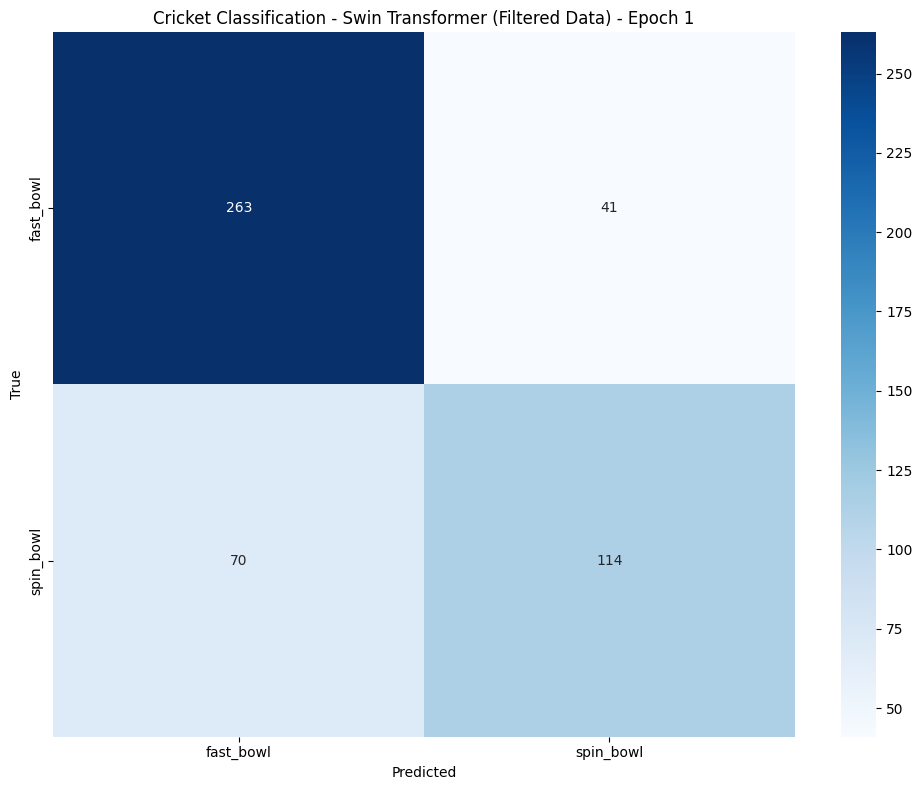

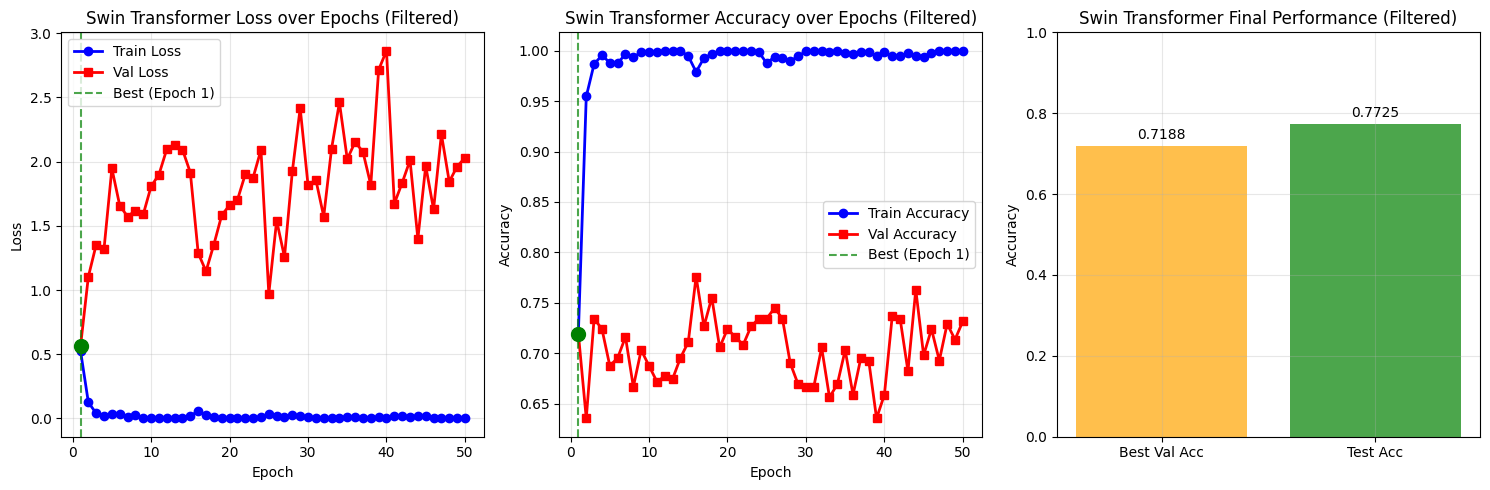


‚è∞ Final Timing Summary:
‚îÇ Total Training: 1840.57s (30.7 min)
‚îÇ Average per Epoch: 36.81s
‚îÇ Testing Time: 8.68s
‚îÇ Total Runtime: 1849.25s

ü™ü Swin Transformer + Filtered Data Benefits:
‚îÇ Clean dataset: 'random_occlusion' folder excluded
‚îÇ Hierarchical architecture: Multi-scale feature extraction
‚îÇ Shifted windows: Efficient computation with cross-window connections
‚îÇ Linear complexity: O(H√óW) instead of O(H¬≤√óW¬≤)
‚îÇ CNNs + Transformers: Best of both architectural worlds
‚îÇ ImageNet-22k pretrained: Superior feature representations
‚îÇ Excellent performance: Often outperforms both CNNs and ViTs


In [8]:
# -----------------------------
# 3. Training Setup
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Lower LR for fine-tuning

print(f"\nüìã Training Configuration:")
print(f"‚îÇ Model: Swin Transformer Tiny (pretrained)")
print(f"‚îÇ Optimizer: Adam (lr={optimizer.param_groups[0]['lr']})")
print(f"‚îÇ Loss Function: CrossEntropyLoss")
print(f"‚îÇ Batch Size: 32")
print(f"‚îÇ Device: {device}")
print(f"‚îÇ Data: Filtered (excluding '{ignore_folder}')")

# -----------------------------
# 4. Training Loop with Model Saving
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking (using val_loss for fine-tuning)
best_val_loss = float('inf')
best_model_state = None
best_epoch = 0
best_val_acc = 0.0

print(f"\nüöÄ Starting Swin Transformer Fine-tuning for {epochs} epochs...")
print("=" * 80)
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\nüìà Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("üîÑ Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc="Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"‚úÖ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("üîç Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc="Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"‚úÖ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model (using val_loss for fine-tuning)
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"üåü New best model found! Validation Loss: {val_loss:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\nüìä Epoch {epoch+1} Summary:")
    print(f"‚îÇ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"‚îÇ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"‚îÇ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"‚îÇ Total Epoch Time: {epoch_time:.2f}s")
    print(f"‚îÇ Best Val Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"‚îÇ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_cricket_swin_filtered_pretrained.pth')
    print(f"\nüíæ Best model saved as 'best_cricket_swin_filtered.pth'")
    print(f"üìä Best model stats:")
    print(f"‚îÇ Best Epoch: {best_epoch}")
    print(f"‚îÇ Best Val Loss: {best_val_loss:.4f}")
    print(f"‚îÇ Best Val Acc: {best_val_acc:.4f}")

# Save training history
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}

history_df = pd.DataFrame(history_data)
history_df.to_csv('cricket_swin_filtered_history_pretrained.csv', index=False)
print("\nüíæ Training history saved to 'cricket_swin_filtered_history_pretrained.csv'")

print(f"\nüéâ Swin Transformer Fine-tuning Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\nüß™ Loading Best Model for Testing...")
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"‚úÖ Best model from epoch {best_epoch} loaded successfully!")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()
test_pbar = tqdm(test_loader, desc="Testing", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"‚úÖ Testing completed in {test_time:.2f}s")
print("\nüìã Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"üéØ Test Accuracy: {test_accuracy:.4f}")

# Performance Summary
print(f"\nüìä Cricket Classification Performance (Swin Transformer - Filtered Data):")
print(f"‚îÇ Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
print(f"‚îÇ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"‚îÇ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"‚îÇ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")
print(f"‚îÇ Data Filtering: Excluded '{ignore_folder}' folder")

print(f"\nüíæ Files saved:")
print(f"‚îÇ best_cricket_swin_filtered.pth - Best model weights")
print(f"‚îÇ cricket_swin_filtered_history.csv - Training metrics")

# -----------------------------
# 6. Visualizations
# -----------------------------
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Cricket Classification - Swin Transformer (Filtered Data) - Epoch {best_epoch}")
plt.tight_layout()
plt.show()

# Training Curves
plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_loss], color='green', s=100, zorder=5)
plt.legend()
plt.title("Swin Transformer Loss over Epochs (Filtered)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='green', s=100, zorder=5)
plt.legend()
plt.title("Swin Transformer Accuracy over Epochs (Filtered)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Final Performance
plt.subplot(1, 3, 3)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['orange', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("Swin Transformer Final Performance (Filtered)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Final Summary
print(f"\n‚è∞ Final Timing Summary:")
print(f"‚îÇ Total Training: {total_training_time:.2f}s ({total_training_time/60:.1f} min)")
print(f"‚îÇ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"‚îÇ Testing Time: {test_time:.2f}s")
print(f"‚îÇ Total Runtime: {total_training_time + test_time:.2f}s")

# Model and Data Info
print(f"\nü™ü Swin Transformer + Filtered Data Benefits:")
print(f"‚îÇ Clean dataset: '{ignore_folder}' folder excluded")
print(f"‚îÇ Hierarchical architecture: Multi-scale feature extraction")
print(f"‚îÇ Shifted windows: Efficient computation with cross-window connections")
print(f"‚îÇ Linear complexity: O(H√óW) instead of O(H¬≤√óW¬≤)")
print(f"‚îÇ CNNs + Transformers: Best of both architectural worlds")
print(f"‚îÇ ImageNet-22k pretrained: Superior feature representations")
print(f"‚îÇ Excellent performance: Often outperforms both CNNs and ViTs")